# FOM finite difference vs integral of autograd derivative

Can take the gradient of the figure of merit in two ways:
* Finite difference using the FOM function directly
* Use `adaptive` to integrate the autograd gradient of $F_D$

Generally speaking, you use the first method as a baseline to check that the second method works correctly and go on to use the second method in your computations. But in this case, both calculations rely on `adaptive` integration over a finite number of sample points. This means that one method may converge faster than the other with respect to the number of sample points, so we don't know which one is the "correct" one. Generally want to use the second method, but not if it requires many more adaptive points to converge than the first method. Hence, to check the true answer, can use a very large number of sample points for both methods, ensure they both converge to the same somewhat-true value (still limited by numerical precision) and then compare the convergence rate of the two methods with respect to number of sample points.

### Setup

In [ ]:
"""
Testing autograd derivatives of FOM are consistent with finite difference derivatives
"""
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

import pickle

import sys
sys.path.append("../")

from parameters import D1_ND
import Optimisation.opt as opt
from twobox import TwoBox


# SETTINGS ################################################################################################
np.random.seed(2025)
abs_tol = 0.5
rel_tol = 0.1
Delta = 1e-7

Nx = 100
nG = 25
Doppler = D1_ND([0.2,0])


# Test gratings
standard_params = [1.4, 0.7, 0.15, 0.35, 0.6, 9., 9., 20., 1., 1.45**2]
standard_grating = TwoBox(*standard_params, wavelength=1., angle=0., Nx=Nx, nG=nG, Qabs=np.inf)
# standard_grating.show_permittivity(show_analytic_box=True)

near_cutoff_params = [1.999, 0.7, 0.15, 0.35, 0.6, 9., 9., 20., 1., 1.45**2] 
near_cutoff_grating = TwoBox(*near_cutoff_params, wavelength=1., angle=0., Nx=Nx, nG=nG, Qabs=np.inf)

thin_pillars_params = [1.4, 0.7, 0.01, 0.01, 0.6, 9., 9., 20., 1., 1.45**2]
thin_pillars_grating = TwoBox(*thin_pillars_params, wavelength=1., angle=0., Nx=Nx, nG=nG, Qabs=np.inf)

closebox_params = [1.4, 0.7, 0.15, 0.35, 0.27, 9., 9., 20., 1., 1.45**2]
closebox_grating = TwoBox(*closebox_params, wavelength=1., angle=0., Nx=Nx, nG=nG, Qabs=np.inf)

overlap_params = [1.4, 0.7, 0.15, 0.35, 0.15, 12., 9., 20., 1., 1.45**2]
overlap_grating = TwoBox(*overlap_params, wavelength=1., angle=0., Nx=Nx, nG=nG, Qabs=np.inf)

clipbox_params = [1.4, 0.7, 0.35, 0.9, 1.1, 9., 9., 20., 1., 1.45**2]
clipbox_grating = TwoBox(*clipbox_params, wavelength=1., angle=0., Nx=Nx, nG=nG, Qabs=np.inf)


def FOM_params_func(grating, params, goal=0.5, return_grad=False):
    grating_pitch, grating_depth, box1_width, box2_width, box_centre_dist, box1_eps, box2_eps, gaussian_width, substrate_depth, substrate_eps = params
    grating.grating_pitch = grating_pitch
    grating.grating_depth = grating_depth
    grating.box1_width = box1_width
    grating.box2_width = box2_width
    grating.box_centre_dist = box_centre_dist
    grating.box1_eps = box1_eps
    grating.box2_eps = box2_eps
    grating.gaussian_width = gaussian_width
    grating.substrate_depth = substrate_depth
    grating.substrate_eps = substrate_eps
    return opt.FOM_uniform(grating, 20., goal, return_grad)


def finite_grad(func, grating, params, Delta, **kwargs):
    """
    Calculate gradient of 'func' at input 'params' using finite difference with respect to each component

    Parameters
    ----------
    func    :   Function of grating
    grating :   Grating to calculate finite difference
    params  :   Parameters for func to differentiate with respect to
    Delta   :   Finite difference step size for each component
    kwargs  :   Kwargs to pass to func
    """

    finitediff_coeffs = [-1/2, 1/2]
    finite_diff_grad = np.zeros(len(params), dtype=np.float32)
    for idx, p in enumerate(params):
        params_plus = params[:]
        params_minus = params[:]
        
        params_plus[idx] += Delta
        params_minus[idx] -= Delta

        dFOM_dp = 0
        params_stepped = [params_minus, params_plus]
        for c, pars in zip(finitediff_coeffs, params_stepped):
            dFOM_dp += c*func(grating, pars, **kwargs)/Delta
        finite_diff_grad[idx] = dFOM_dp
    
    return finite_diff_grad

### Calculate converged gradient (large number of sample points)

In [ ]:
import time
import pickle

# Choose test grating
loss_goal = 0.01
choose_grating = standard_grating
grating_name = "standard_grating"

test_grating = deepcopy(choose_grating)
params = test_grating.params[:]

# Finite diff
finite_t0 = time.time()
finite_diff_grad = finite_grad(FOM_params_func, test_grating, params, Delta, goal=loss_goal)
finite_t1 = time.time()
finite_runtime = finite_t1-finite_t0

# Auto diff
auto_t0 = time.time()
auto_diff_grad = np.array(FOM_params_func(test_grating, params, goal=loss_goal, return_grad=True)[1])
auto_t1 = time.time()
auto_runtime = auto_t1-auto_t0

# Save results
fname = f"./Data/{grating_name}_true_gradient_loss{loss_goal}_Nx{Nx}.pkl"
save_data = {'Grating': choose_grating, 'Loss goal': loss_goal, 'True finite grad': finite_diff_grad, 'True auto grad': auto_diff_grad}
with open(fname, 'wb') as data_file:
    pickle.dump(save_data, data_file)

np.set_printoptions(precision=9)
print(f"Integrate autodiff: {auto_diff_grad}")
print(f"Raw FOM finitediff: {finite_diff_grad}")

In [ ]:
print(FOM_params_func(test_grating, params, goal=loss_goal, return_grad=True)[0])

In [ ]:
# NEAR CUTOFF GRATING LvR FOM
# -55427193.446355745
# Integrate autodiff: [ 5.182777456e+08  5.281259160e+08  1.033517864e+09 -2.567619754e+08
#   1.077739805e+09  6.786617338e+07 -2.907117245e+07 -1.050076780e+06
#   1.281703672e+09  8.328210389e+08]
# Raw FOM finitediff: [ 2.2867318e+09  3.8875200e+08  2.1476109e+09  3.3508902e+09
#  -8.7077690e+08  8.5168696e+07  4.9899380e+07 -3.9876538e+05
#   1.1850308e+09  1.0152158e+09]

# NEAR CUTOFF GRATING MdS FOM
# -55427194.08134901
# Integrate autodiff: [ 5.182774839e+08  5.281259201e+08  1.033517848e+09 -2.567620446e+08
#   1.077739823e+09  6.786617246e+07 -2.907117322e+07 -1.050076766e+06
#   1.281703659e+09  8.328210305e+08]
# Raw FOM finitediff: [ 2.2867315e+09  3.8875203e+08  2.1476109e+09  3.3508900e+09
#  -8.7077683e+08  8.5168696e+07  4.9899380e+07 -3.9876528e+05
#   1.1850307e+09  1.0152158e+09]

# NEAR CUTOFF GRATING MdS FOM WITH SOFTMIN AND NO UNIQUENESS CHECK FOR EIGENVALUES
# -55427193.13158919
# Integrate autodiff: [ 5.182778765e+08  5.281259140e+08  1.033517872e+09 -2.567619406e+08
#   1.077739796e+09  6.786617384e+07 -2.907117206e+07 -1.050076788e+06
#   1.281703679e+09  8.328210432e+08]
# Raw FOM finitediff: [ 2.2867318e+09  3.8875200e+08  2.1476109e+09  3.3508902e+09
#  -8.7077690e+08  8.5168696e+07  4.9899380e+07 -3.9876538e+05
#   1.1850308e+09  1.0152158e+09]

### Calculate component-wise gradient error relative to converged gradient 

In [9]:
# Choose converged-gradient-grating parameters to retrieve
Nx = 100
loss_goal = 0.01
choose_grating = standard_grating
grating_name = "standard_grating"

fname = f"./Data/{grating_name}_true_gradient_loss{loss_goal}_Nx{Nx}.pkl"
with open(fname, 'rb') as data_file:
    load_data = pickle.load(data_file)
true_grad = load_data["True auto grad"]

# Test gradient convergence at different loss goals
n_test = 10
loss_goals = np.logspace(np.log10(0.01), 0, n_test, dtype=float)

test_grating = deepcopy(choose_grating)
params = test_grating.params[:]

finite_diff_error = np.zeros((n_test,len(params)), dtype=np.float32)
auto_diff_error = np.zeros((n_test,len(params)), dtype=np.float32)
for g_idx, g in enumerate(loss_goals):
    finite_diff_grad = finite_grad(FOM_params_func, test_grating, params, Delta, goal=g)
    auto_diff_grad = np.array(FOM_params_func(test_grating, params, goal=g, return_grad=True)[1])

    finite_diff_error[g_idx,:] = np.abs((finite_diff_grad - true_grad)/true_grad)
    auto_diff_error[g_idx,:] = np.abs((auto_diff_grad - true_grad)/true_grad)

fname = f"./Data/{grating_name}_gradient_convergence_lossmin{loss_goals[0]:.2f}.pkl"
save_data = {'Grating': choose_grating, 'loss_goals': loss_goals, 'True gradient': true_grad,
             'Finite grad error': finite_diff_error, 'Auto grad error': auto_diff_error}

with open(fname, 'wb') as data_file:
    pickle.dump(save_data, data_file)

### Plot convergence

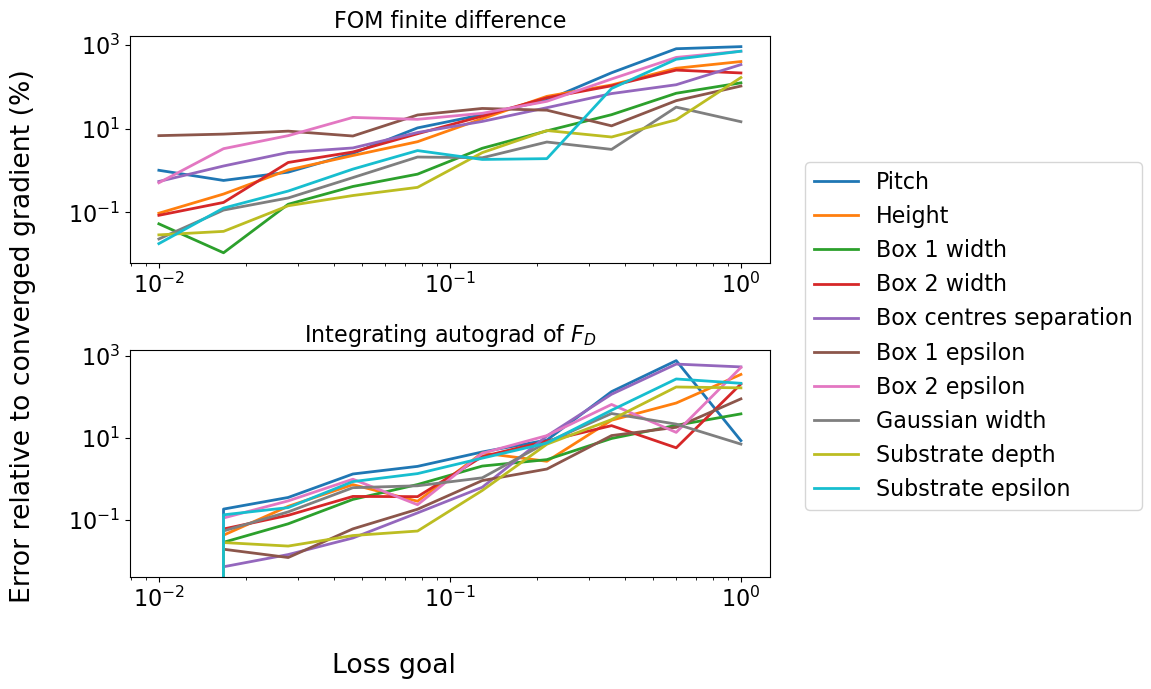

In [10]:
# Choose converged-gradient-grating parameters to retrieve
Nx = 100
grating_name = "standard_grating"
fname = f"./Data/{grating_name}_gradient_convergence_lossmin0.01.pkl"
with open(fname, 'rb') as data_file:
    save_data = pickle.load(data_file)

loss_goals = save_data["loss_goals"]
finite_diff_error = save_data["Finite grad error"]
auto_diff_error = save_data["Auto grad error"]


fig, axs = plt.subplots(2, figsize=(8,7))

shape = finite_diff_error.shape
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
labels = ["Pitch", "Height", "Box 1 width", "Box 2 width", "Box centres separation", 
          "Box 1 epsilon", "Box 2 epsilon", "Gaussian width", "Substrate depth", "Substrate epsilon"]
for component in range(0,shape[1]):
    axs[0].plot(loss_goals, 100*finite_diff_error[:,component], color=colors[component], linewidth=2, label=labels[component])
    axs[1].plot(loss_goals, 100*auto_diff_error[:,component], color=colors[component], linewidth=2)

axs[0].set(title="FOM finite difference")
axs[1].set(title=r"Integrating autograd of $F_D$")

for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')

fig.supxlabel("Loss goal")
fig.supylabel("Error relative to converged gradient (%)")
fig.legend(loc="center left",bbox_to_anchor=(1.,0.5))

plt.tight_layout()
fig.savefig(f"./Data/{grating_name}_gradient_convergence_lossmin{loss_goals[0]}.pdf", bbox_inches='tight')